In [14]:
from typing import TypeAlias, TypeVar, Protocol
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.figure import Figure
from matplotlib.axes import Axes

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Type aliases
ArrayLike: TypeAlias = np.ndarray
DatasetType: TypeAlias = tuple[ArrayLike, ArrayLike, str]

# Define a protocol for classifiers
class ClassifierProtocol(Protocol):
    def fit(self, X: ArrayLike, y: ArrayLike) -> 'ClassifierProtocol':
        ...
    
    def predict(self, X: ArrayLike) -> ArrayLike:
        ...
    
    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        ...

T = TypeVar('T', bound=ClassifierProtocol)

class MultiClassWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, clf: T) -> None:
        self.clf = clf

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'MultiClassWrapper':
        self.classes_ = np.unique(y)
        self.clf.fit(X, y)
        return self

    def predict(self, X: ArrayLike) -> ArrayLike:
        return self.clf.predict(X)

    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        if hasattr(self.clf, "predict_proba"):
            return self.clf.predict_proba(X)
        else:
            # If the classifier doesn't have predict_proba, use decision_function
            df = self.clf.decision_function(X)
            if df.ndim == 1:
                return np.column_stack([1 / (1 + np.exp(-df)), 1 / (1 + np.exp(df))])
            else:
                return np.exp(df) / np.sum(np.exp(df), axis=1)[:, np.newaxis]

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        return self.clf.score(X, y)

def plot_classifier_comparison(
    classifiers: dict[str, ClassifierProtocol],
    datasets: list[DatasetType]
) -> Figure:
    # Use Fira Sans as the font
    plt.rcParams['font.family'] = 'Fira Sans'

    # Define a modern color palette
    color_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#20B2AA', '#87CEFA']
    cm_bright = ListedColormap(color_palette)

    n_classifiers = len(classifiers)
    n_datasets = len(datasets)
    
    # Adjust figure size to ensure consistent plot heights
    fig, axes = plt.subplots(n_datasets, n_classifiers + 1, 
                             figsize=(2.7 * (n_classifiers + 1), 2.5 * n_datasets),
                             squeeze=False)

    # iterate over datasets
    for ds_cnt, (X, y, ds_name) in enumerate(datasets):
        X = X[:, :2]
        
        # preprocess dataset, split into training and test part
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )
        print(f"\nProcessing dataset: {ds_name}")
        print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
        print(f"Unique labels: {np.unique(y)}")



        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        # just plot the dataset first
        ax = axes[ds_cnt, 0]
        plot_dataset(ax, X_train, y_train, X_test, y_test, ds_name, x_min, x_max, y_min, y_max, cm_bright, ds_cnt == 0)

        # iterate over classifiers
        for clf_cnt, (name, clf) in enumerate(classifiers.items()):
            ax = axes[ds_cnt, clf_cnt + 1]
            plot_classifier(ax, clf, X_train, y_train, X_test, y_test, x_min, x_max, y_min, y_max, cm_bright, color_palette, name, ds_cnt == 0)

            
            if isinstance(clf, JAXKNN):
                clf = JAXKNN(k=int(name.split("-")[0]))
            clf.fit(X_train, y_train)
            if isinstance(clf, JAXKNN):
                clf.check_state()
                print("KNN predictions:")
                predictions = clf.predict(X_test)
                print(f"First few predictions: {predictions[:10]}")
                print(f"First few true labels: {y_test[:10]}")
                print(f"Unique predicted values: {np.unique(predictions)}")
                print(f"Unique true values: {np.unique(y_test)}")
            
            # Calculate and print the score
            score = clf.score(X_test, y_test)
            print(f"\nClassifier: {name}")

            print(f"Dataset: {ds_name}, Classifier: {name}, Score: {score:.4f}")


    # Add grid lines between plots
    for i in range(1, n_datasets):
        plt.axhline(y=i/n_datasets, color='#D3D3D3', linestyle='-', linewidth=0.5)
    for i in range(1, n_classifiers + 1):
        plt.axvline(x=i/(n_classifiers + 1), color='#D3D3D3', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    return fig

def plot_dataset(
    ax: Axes,
    X_train: ArrayLike,
    y_train: ArrayLike,
    X_test: ArrayLike,
    y_test: ArrayLike,
    ds_name: str,
    x_min: float,
    x_max: float,
    y_min: float,
    y_max: float,
    cm_bright: ListedColormap,
    is_first: bool
) -> None:
    if is_first:
        ax.set_title("Input data")
    # Plot the training points
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    # Remove frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add dataset name
    ax.text(x_min + 0.5, y_min + 0.5, ds_name, fontsize=10, verticalalignment='top')
    # Add legend
    ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")

def plot_classifier(
    ax: Axes,
    clf: ClassifierProtocol,
    X_train: ArrayLike,
    y_train: ArrayLike,
    X_test: ArrayLike,
    y_test: ArrayLike,
    x_min: float,
    x_max: float,
    y_min: float,
    y_max: float,
    cm_bright: ListedColormap,
    color_palette: list[str],
    name: str,
    is_first: bool
) -> None:
    #clf = make_pipeline(StandardScaler(), MultiClassWrapper(clf))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary with probabilities
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    
    # For multi-class, blend the probabilities
    n_classes = Z.shape[1]
    Z_rgb = np.zeros((Z.shape[0], 4))  # RGBA
    for j in range(n_classes):
        color = to_rgb(color_palette[j % len(color_palette)])
        Z_rgb[:, :3] += Z[:, j, np.newaxis] * color
    
    # Normalize RGB values
    Z_rgb[:, :3] /= Z_rgb[:, :3].max(axis=1, keepdims=True)
    
    # Set alpha channel based on maximum probability
    max_prob = np.max(Z, axis=1)
    Z_rgb[:, 3] = max_prob
    
    Z_rgb = Z_rgb.reshape(xx.shape[0], xx.shape[1], 4)
    ax.imshow(Z_rgb, extent=(x_min, x_max, y_min, y_max), origin='lower', interpolation='nearest')

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    if is_first:
        ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        f"Accuracy: {score:.2f}",  # Changed this line to show "Accuracy: X.XX"
        size=10,  # Reduced size for better fit
        horizontalalignment='right',
        fontweight='bold',
        color='#333333'
    )
    # Remove frame
    for spine in ax.spines.values():
        spine.set_visible(False)



Processing dataset: Noisy moons
Train set shape: (60, 2), Test set shape: (40, 2)
Unique labels: [0 1]

Classifier: Softmax Regression
Dataset: Noisy moons, Classifier: Softmax Regression, Score: 0.8750

Classifier: Nearest Centroid
Dataset: Noisy moons, Classifier: Nearest Centroid, Score: 0.8500
Fitting KNN with input shape: (60, 2), labels shape: (60,)
Fitted KNN with 60 samples, 2 classes
Scoring KNN with input shape: (40, 2), labels shape: (40,)
Predicting with KNN for input shape: (40, 2)
KNN predictions shape: (40,), unique values: [0 1]
KNN accuracy: 0.9750
Predicting probabilities with KNN for input shape: (10000, 2)
KNN probabilities shape: (10000, 2)
Fitting KNN with input shape: (60, 2), labels shape: (60,)
Fitted KNN with 60 samples, 2 classes
KNN state: X_train shape: (60, 2), y_train shape: (60,), n_classes: [0 1]
KNN predictions:
Predicting with KNN for input shape: (40, 2)
KNN predictions shape: (40,), unique values: [0 1]
First few predictions: [0 0 0 0 0 1 0 0 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Classifier: Softmax Regression
Dataset: Less noisy linear, Classifier: Softmax Regression, Score: 1.0000

Classifier: Nearest Centroid
Dataset: Less noisy linear, Classifier: Nearest Centroid, Score: 1.0000
Fitting KNN with input shape: (60, 2), labels shape: (60,)
Fitted KNN with 60 samples, 2 classes
Scoring KNN with input shape: (40, 2), labels shape: (40,)
Predicting with KNN for input shape: (40, 2)
KNN predictions shape: (40,), unique values: [0 1]
KNN accuracy: 1.0000
Predicting probabilities with KNN for input shape: (10000, 2)
KNN probabilities shape: (10000, 2)
Fitting KNN with input shape: (60, 2), labels shape: (60,)
Fitted KNN with 60 samples, 2 classes
KNN state: X_train shape: (60, 2), y_train shape: (60,), n_classes: [0 1]
KNN predictions:
Predicting with KNN for input shape: (40, 2)
KNN predictions shape: (40,), unique values: [0 1]
First few predictions: [1 1 0 0 1 0 1 0 0 1]
First few true labels: [1 1 0 0 1 0 1 0 0 1]
Unique predicted values: [0 1]
Unique true valu

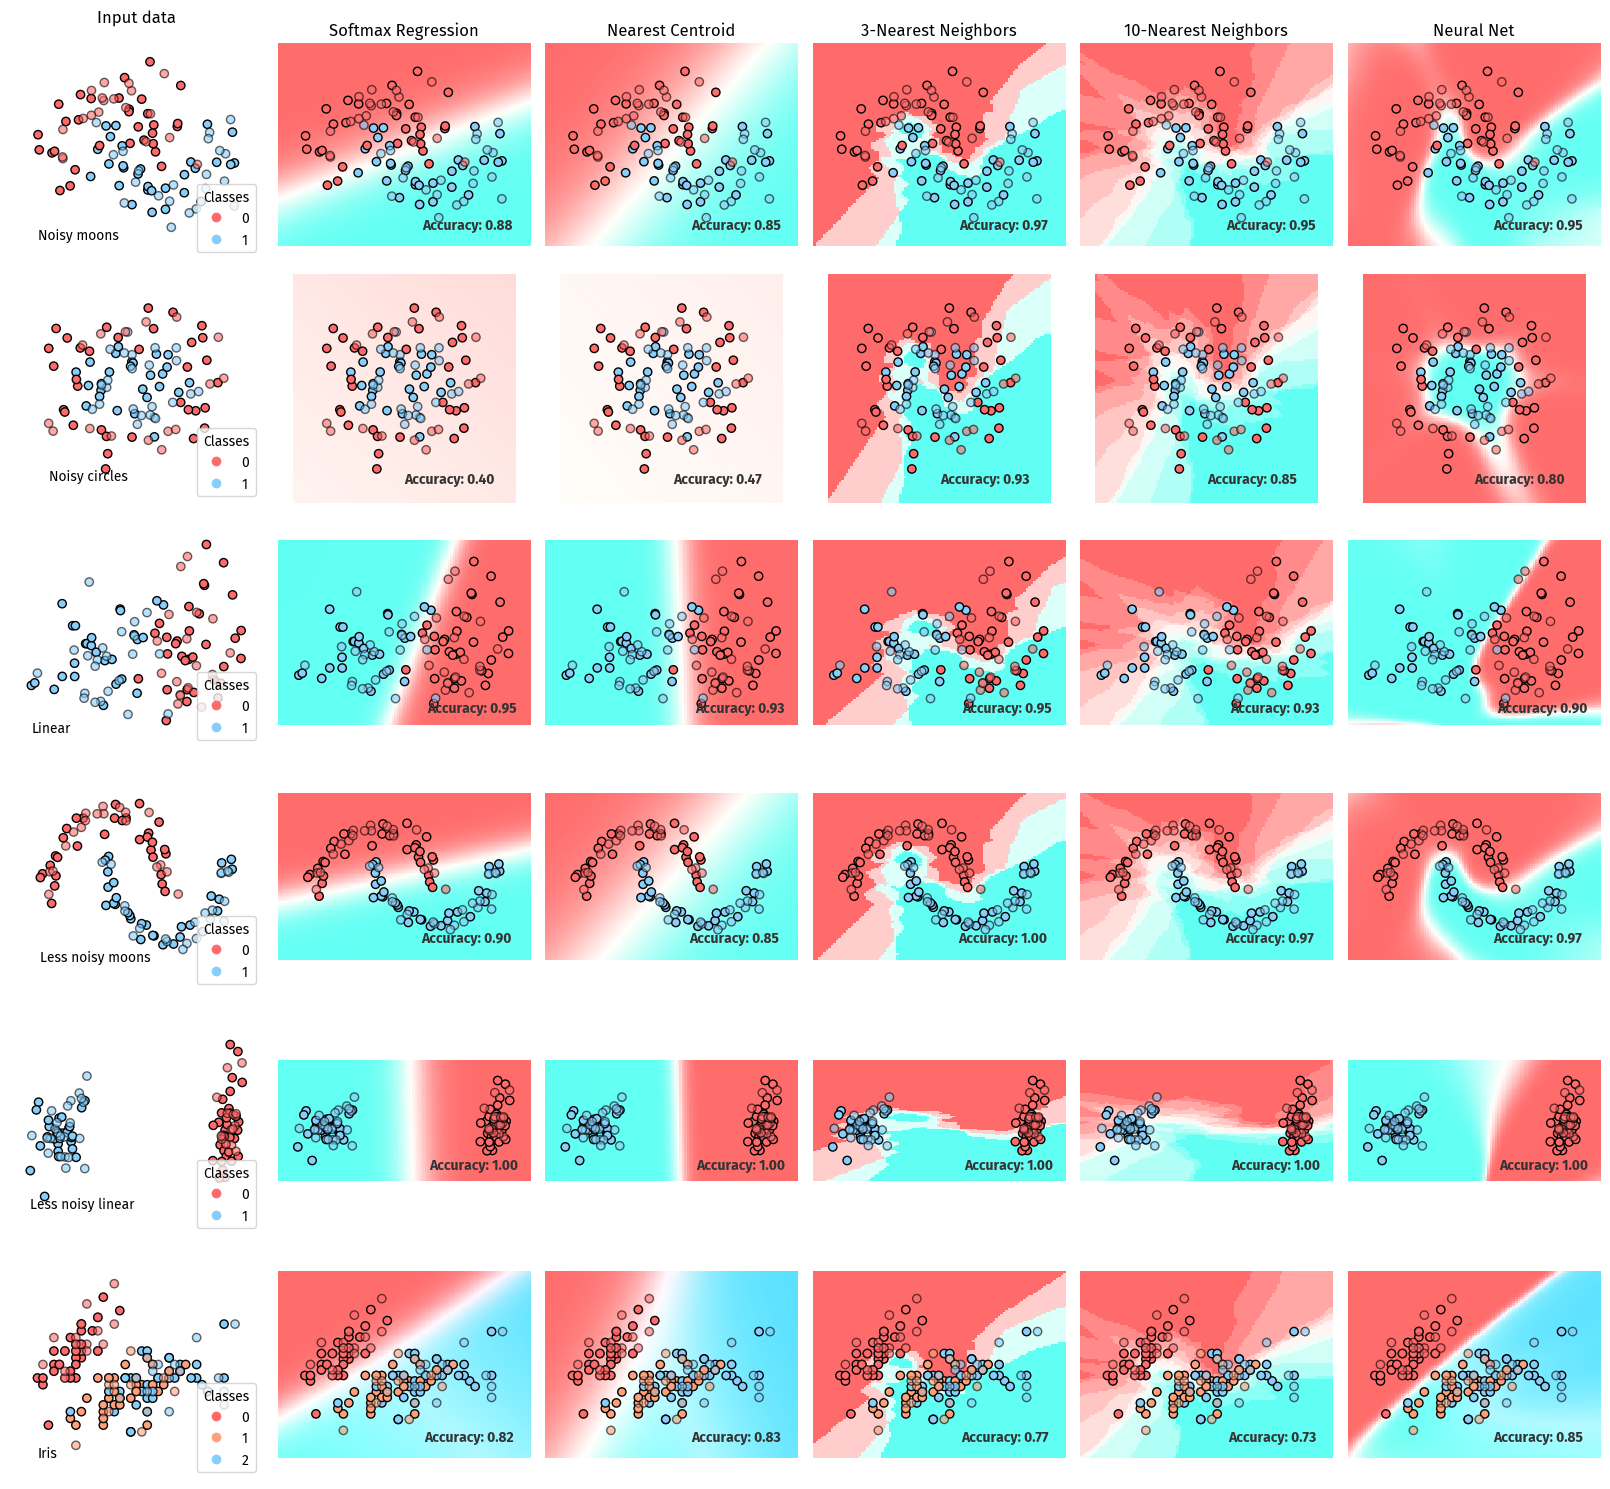

In [16]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
from functools import partial
from typing import TypeAlias, Any, Tuple, Callable
import numpy as np


ArrayLike: TypeAlias = jnp.ndarray | np.ndarray

def to_numpy(x: ArrayLike) -> np.ndarray:
    """Convert JAX array to NumPy array."""
    return np.array(x)

def jax_to_numpy_method(func: Callable) -> Callable:
    """Decorator to convert JAX output to NumPy array."""
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return to_numpy(result)
    return wrapper

class OptimizableMixin:
    def __init__(self, learning_rate: float = 0.1, num_epochs: int = 100):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.optimizer = optax.adam(learning_rate)

    def update(self, params: Any, opt_state: Any, X: ArrayLike, y: ArrayLike) -> Tuple[Any, Any]:
        loss_value, grads = jax.value_and_grad(self.loss)(params, X, y)
        updates, opt_state = self.optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

class JAXSoftmaxRegression(OptimizableMixin):
    def __init__(self, num_classes: int, learning_rate: float = 0.1, num_epochs: int = 100):
        super().__init__(learning_rate, num_epochs)
        self.num_classes = num_classes
        self.params = None

    def loss(self, params: Tuple[ArrayLike, ArrayLike], X: ArrayLike, y: ArrayLike) -> float:
        W, b = params
        logits = jnp.dot(X, W) + b
        return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=1))

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'JAXSoftmaxRegression':
        X = jnp.array(X)
        y = jax.nn.one_hot(jnp.array(y), self.num_classes)
        n_features = X.shape[1]
        
        key = jax.random.PRNGKey(0)
        W = jax.random.normal(key, (n_features, self.num_classes)) * 0.01
        b = jnp.zeros((self.num_classes,))
        self.params = (W, b)
        opt_state = self.optimizer.init(self.params)

        for _ in range(self.num_epochs):
            self.params, opt_state = self.update(self.params, opt_state, X, y)

        return self

    @jax_to_numpy_method
    def predict(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        W, b = self.params
        logits = jnp.dot(X, W) + b
        return jnp.argmax(jax.nn.softmax(logits), axis=1)

    @jax_to_numpy_method
    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        W, b = self.params
        logits = jnp.dot(X, W) + b
        return jax.nn.softmax(logits)

    @jax_to_numpy_method
    def decision_function(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        W, b = self.params
        return jnp.dot(X, W) + b

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        return np.mean(self.predict(X) == y)

class JAXNearestCentroid:
    def __init__(self):
        self.centroids = None
        self.classes = None

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'JAXNearestCentroid':
        X = jnp.array(X)
        y = jnp.array(y)
        self.classes = jnp.unique(y)
        
        # Calculate centroids using a JAX-friendly approach
        def calculate_centroid(c):
            mask = y == c
            count = jnp.sum(mask)
            centroid = jnp.sum(X * mask[:, jnp.newaxis], axis=0) / count
            return centroid
        
        self.centroids = jax.vmap(calculate_centroid)(self.classes)
        return self

    @jax_to_numpy_method
    def predict(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        distances = jax.vmap(lambda x: jnp.sum((self.centroids - x[jnp.newaxis, :]) ** 2, axis=1))(X)
        return self.classes[jnp.argmin(distances, axis=1)]

    @jax_to_numpy_method
    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        distances = jax.vmap(lambda x: jnp.sum((self.centroids - x[jnp.newaxis, :]) ** 2, axis=1))(X)
        exp_distances = jnp.exp(-distances)
        return exp_distances / jnp.sum(exp_distances, axis=1, keepdims=True)

    @jax_to_numpy_method
    def decision_function(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        return -jax.vmap(lambda x: jnp.sum((self.centroids - x[jnp.newaxis, :]) ** 2, axis=1))(X)

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        return np.mean(self.predict(X) == y)

class JAXKNN:
    def __init__(self, k: int = 3, use_kernel: bool = False, sigma: float = 1.0):
        self.k = k
        self.use_kernel = use_kernel
        self.sigma = sigma
        self.X_train = None
        self.y_train = None
        self.classes_ = None
        self.scaler = StandardScaler()

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'JAXKNN':
        print(f"Fitting KNN with input shape: {X.shape}, labels shape: {y.shape}")
        X_scaled = self.scaler.fit_transform(X)
        self.X_train = jnp.array(X_scaled)
        self.classes_, y_encoded = jnp.unique(y, return_inverse=True)
        self.y_train = jnp.array(y_encoded)
        print(f"Fitted KNN with {self.X_train.shape[0]} samples, {len(self.classes_)} classes")
        return self

    def gaussian_distance(self, x: ArrayLike) -> ArrayLike:
        distances = jnp.sum((self.X_train - x) ** 2, axis=1)
        return jnp.exp(-distances / (2 * self.sigma ** 2))

    #@partial(jit, static_argnums=(0,))
    def predict_single(self, x: ArrayLike) -> int:
        if self.use_kernel:
            similarities = self.gaussian_distance(x)
            nearest_neighbor_ids = jnp.argsort(-similarities)[:self.k]
        else:
            distances = jnp.sum((self.X_train - x) ** 2, axis=1)
            nearest_neighbor_ids = jnp.argsort(distances)[:self.k]
        votes = jnp.bincount(self.y_train[nearest_neighbor_ids], length=len(self.classes_))
        return self.classes_[jnp.argmax(votes)]

    @jax_to_numpy_method
    def predict(self, X: ArrayLike) -> np.ndarray:
        print(f"Predicting with KNN for input shape: {X.shape}")
        X_scaled = self.scaler.transform(X)
        X_scaled = jnp.array(X_scaled)
        predictions = jax.vmap(self.predict_single)(X_scaled)
        print(f"KNN predictions shape: {predictions.shape}, unique values: {np.unique(predictions)}")
        return predictions

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        print(f"Scoring KNN with input shape: {X.shape}, labels shape: {y.shape}")
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        print(f"KNN accuracy: {accuracy:.4f}")
        return accuracy

    #@partial(jit, static_argnums=(0,))
    def predict_proba_single(self, x: ArrayLike) -> ArrayLike:
        if self.use_kernel:
            similarities = self.gaussian_distance(x)
            nearest_neighbor_ids = jnp.argsort(-similarities)[:self.k]
        else:
            distances = jnp.sum((self.X_train - x) ** 2, axis=1)
            nearest_neighbor_ids = jnp.argsort(distances)[:self.k]
        votes = jnp.bincount(self.y_train[nearest_neighbor_ids], length=len(self.classes_))
        return votes / self.k
    
    @jax_to_numpy_method
    def predict_proba(self, X: ArrayLike) -> np.ndarray:
        print(f"Predicting probabilities with KNN for input shape: {X.shape}")
        X_scaled = self.scaler.transform(X)
        X_scaled = jnp.array(X_scaled)
        probabilities = jax.vmap(self.predict_proba_single)(X_scaled)
        print(f"KNN probabilities shape: {probabilities.shape}")
        return probabilities
    
    def check_state(self):
        print(f"KNN state: X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}, n_classes: {self.classes_}")


def gaussian_activation(x: ArrayLike) -> ArrayLike:
    return jnp.exp(-x**2)

class JAXMLP(OptimizableMixin):
    def __init__(self, hidden_dim: int = 100, num_classes: int = 3, learning_rate: float = 0.01, num_epochs: int = 100, activation: Callable = gaussian_activation):
        super().__init__(learning_rate, num_epochs)
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.params = None
        self.activation = activation

    def init_params(self, input_dim: int) -> dict[str, ArrayLike]:
        key = jax.random.PRNGKey(0)
        return {
            'W1': jax.random.normal(key, (input_dim, self.hidden_dim)) * jnp.sqrt(2.0 / input_dim),
            'b1': jnp.zeros((self.hidden_dim,)),
            'W2': jax.random.normal(key, (self.hidden_dim, self.num_classes)) * jnp.sqrt(2.0 / self.hidden_dim),
            'b2': jnp.zeros((self.num_classes,))
        }

    def forward(self, params: dict[str, ArrayLike], X: ArrayLike) -> ArrayLike:
        H = self.activation(jnp.dot(X, params['W1']) + params['b1'])
        return jnp.dot(H, params['W2']) + params['b2']

    def loss(self, params: dict[str, ArrayLike], X: ArrayLike, y: ArrayLike) -> float:
        logits = self.forward(params, X)
        return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=1))

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'JAXMLP':
        X = jnp.array(X)
        y = jax.nn.one_hot(jnp.array(y), self.num_classes)
        self.params = self.init_params(X.shape[1])
        opt_state = self.optimizer.init(self.params)

        for _ in range(self.num_epochs):
            self.params, opt_state = self.update(self.params, opt_state, X, y)

        return self

    @jax_to_numpy_method
    def predict(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        logits = self.forward(self.params, X)
        return jnp.argmax(jax.nn.softmax(logits), axis=1)

    @jax_to_numpy_method
    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        logits = self.forward(self.params, X)
        return jax.nn.softmax(logits)

    @jax_to_numpy_method
    def decision_function(self, X: ArrayLike) -> ArrayLike:
        X = jnp.array(X)
        return self.forward(self.params, X)

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        return np.mean(self.predict(X) == y)


if __name__ == "__main__":
    from sklearn.datasets import make_moons, make_circles, make_classification, load_iris
    from sklearn.model_selection import train_test_split

    classifiers = {
        "Softmax Regression": JAXSoftmaxRegression(num_classes=3),
        "Nearest Centroid": JAXNearestCentroid(),
        "3-Nearest Neighbors": JAXKNN(k=3),
        "10-Nearest Neighbors": JAXKNN(k=10),
        "Neural Net": JAXMLP(hidden_dim=100, num_classes=3),
    }

    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, 
                               random_state=1, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    iris = load_iris()
    
    datasets = [
        (*make_moons(n_samples=100, noise=0.3, random_state=0), "Noisy moons"),
        (*make_circles(n_samples=100, noise=0.2, factor=0.5, random_state=1), "Noisy circles"),
        (*linearly_separable, "Linear"),
        (*make_moons(n_samples=100, noise=0.1, random_state=0), "Less noisy moons"),
        (*make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, 
                             n_clusters_per_class=1, class_sep=2.0), "Less noisy linear"),
        (iris.data, iris.target, "Iris")
    ]

    fig = plot_classifier_comparison(classifiers, datasets)
    fig.savefig('classifier_comparison.png')
    print("Classifier comparison plot saved as 'classifier_comparison.png'")

In [13]:
def debug_knn(knn, X_train, y_train, X_test, y_test):
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_pred_proba = knn.predict_proba(X_test)
    
    print("First few predictions:", y_pred[:10])
    print("First few true labels:", y_test[:10])
    print("First few prediction probabilities:")
    print(y_pred_proba[:5])
    
    accuracy = knn.score(X_test, y_test)
    print(f"KNN Accuracy: {accuracy}")
    
    # Manual accuracy calculation
    manual_accuracy = np.mean(y_pred == y_test)
    print(f"Manual Accuracy: {manual_accuracy}")
    
    # Check unique values
    print("Unique predicted values:", np.unique(y_pred))
    print("Unique true values:", np.unique(y_test))
    
    return y_pred, y_pred_proba


print("Debug output:")
# Debug KNN on all datasets
for X, y, name in datasets:
    print(f"\nDebugging KNN on dataset: {name}")
    X_train, X_test, y_train, y_test = train_test_split(X[:, :2], y, test_size=0.4, random_state=42)
    knn = JAXKNN(k=3)
    y_pred, y_pred_proba = debug_knn(knn, X_train, y_train, X_test, y_test)


Debug output:

Debugging KNN on dataset: Noisy moons
Fitting KNN with input shape: (60, 2), labels shape: (60,)
Fitted KNN with 60 samples, 2 classes
Predicting with KNN for input shape: (40, 2)
KNN predictions shape: (40,), unique values: [0 1]
Predicting probabilities with KNN for input shape: (40, 2)
KNN probabilities shape: (40, 2)
First few predictions: [0 0 0 0 0 1 0 0 1 0]
First few true labels: [0 0 0 0 0 1 0 0 1 0]
First few prediction probabilities:
[[1.         0.        ]
 [0.6666667  0.33333334]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]
Scoring KNN with input shape: (40, 2), labels shape: (40,)
Predicting with KNN for input shape: (40, 2)
KNN predictions shape: (40,), unique values: [0 1]
KNN accuracy: 0.9750
KNN Accuracy: 0.975
Manual Accuracy: 0.975
Unique predicted values: [0 1]
Unique true values: [0 1]

Debugging KNN on dataset: Noisy circles
Fitting KNN with input shape: (60, 2), labels shape: (60,)
Fitted KNN with 60 samples, 2 clas